EV ADOPTION FORECASTING

In [8]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
import pandas as pd

# Load the dataset (update path as needed)
df = pd.read_csv("/content/3ae033f50fa345051652.csv")

In [11]:
# Check Dataset Dimensions
print("Dataset Shape:", df.shape)

Dataset Shape: (20819, 10)


In [12]:
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7.0,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3.0,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1.0,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0.0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1.0,83,84,1.19


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  float64
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(2), object(8)
memory us

In [14]:
df.isnull().sum()

,0
Date,0
County,86
State,86
Vehicle Primary Use,0
Battery Electric Vehicles (BEVs),0
Plug-In Hybrid Electric Vehicles (PHEVs),0
Electric Vehicle (EV) Total,0
Non-Electric Vehicle Total,0
Total Vehicles,0
Percent Electric Vehicles,0


Checking if any column contain Outliners

In [15]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


Data Processing

In [16]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7.0,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3.0,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1.0,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0.0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1.0,83,84,1.19


In [17]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


Convert all count columns to numeric

In [18]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20819.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,297.579855,132.845312,134.463767,2.122378
std,102.004224,92.309729,2915.504792,174.033916,174.448753,2.277542
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,4.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,89834.000000,999.000000,998.000000,6.902500


In [19]:
# Most EVs by County
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
King         3309850.0
Snohomish     683598.0
Pierce        456003.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Union         1.0
Hood River    1.0
Name: Electric Vehicle (EV) Total, dtype: float64


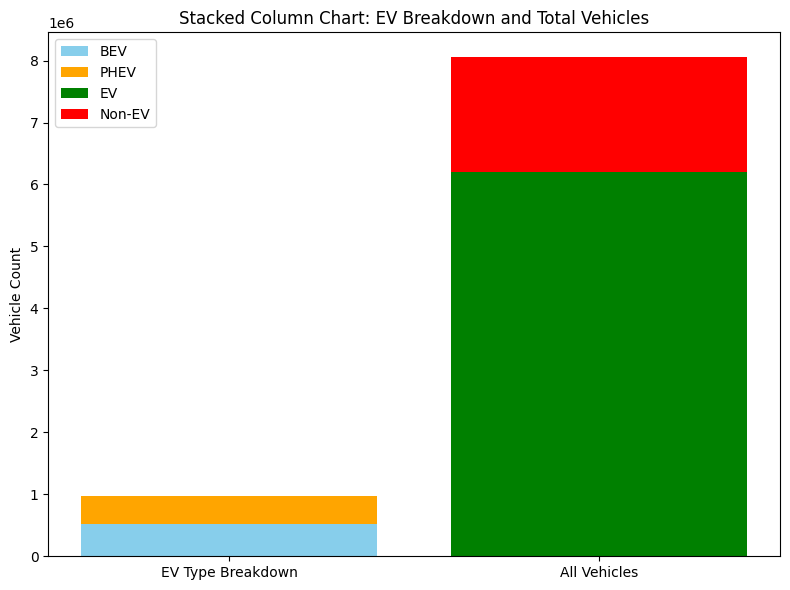

In [20]:
# Total sums for stacked column chart
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(8, 6))

# Stack EV types
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='green')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='red')

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()

Feature Engineering

In [22]:
#Extract year, month, and date
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month  # For trend

In [23]:
# Encode County
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

In [24]:
# Sort for lag creation
df = df.sort_values(['County', 'Date'])

Feature Meaning

ev_total_lagX: How many EVs were registered X months ago
ev_total_roll_mean_3: Smoother average of EV total over the past 3 months
ev_total_pct_change_1: Monthly growth rate (e.g., from 100 → 120 = +20%)
ev_total_pct_change_3: 3-month growth trend (captures momentum)
It does this for each county independently using groupby('County').

In [25]:
# Assign time index per county
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
# === Create lag features (1–3 months) ===
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# === Rolling average (3-month, prior) ===
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [26]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-month rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

In [27]:
# Drop early rows with no lag data

df = df.dropna().reset_index(drop=True)

In [28]:
df.to_csv('preprocessed_ev_data.csv', index=False)

df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [29]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [30]:
X.shape

(12657, 9)

In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [33]:
y_test.head()

,Electric Vehicle (EV) Total
11391,1.0
11392,1.0
11393,1.0
11394,1.0
11395,1.0


Model Selection

In [34]:
# Define param distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # 30 random combos
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [35]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [36]:
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
11391,89,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11392,90,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11393,91,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11394,92,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11395,93,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Model Evaluation
Evaluation Metrics:

Mean Squared Error (MSE) – Penalizes larger errors.  

R² Score – Measures goodness of fit.

In [37]:
# Create a DataFrame with actual and predicted values

comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optionally reset index if needed
comparison_df.reset_index(drop=True, inplace=True)

# Show the first 10 rows
comparison_df.head(10)

,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Actual EV Count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Actual EV Count'}, axis=1)
              .sort_values('Actual EV Count', ascending=True))
  xs = counted['Actual EV Count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('Actual EV Count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Actual EV Count')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Predicted EV Count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Predicted EV Count'}, axis=1)
              .sort_values('Predicted EV Count', ascending=True))
  xs = counted['Predicted EV Count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Predicted EV Count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Predicted EV Count')
_ = plt.ylabel('count()')

In [ ]:
Actual vs Predicted EV Count

MAE: 0.01, RMSE: 0.06, R2 Score: 1.00


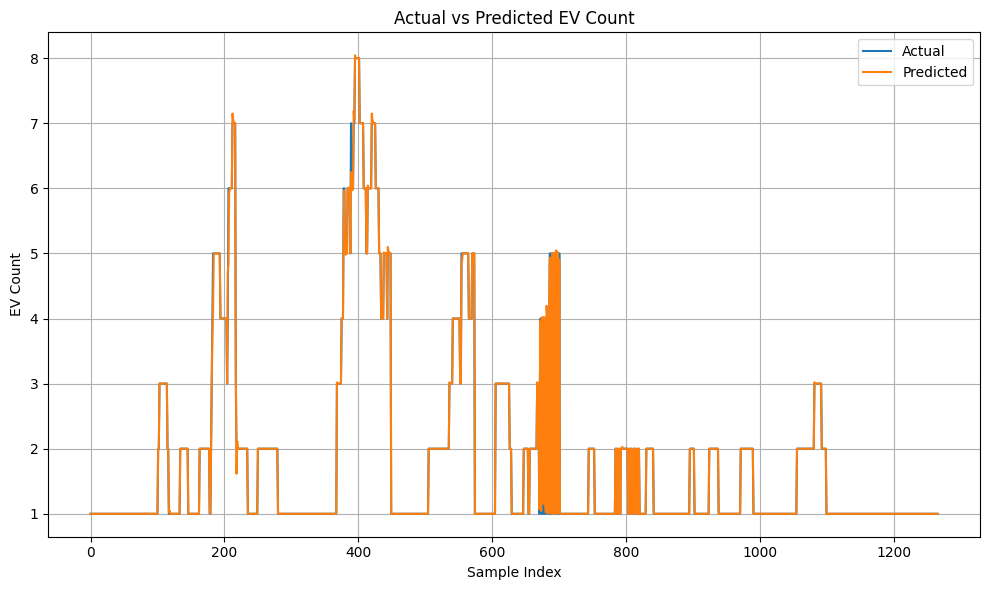

In [38]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

evaluate(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Feature Importance

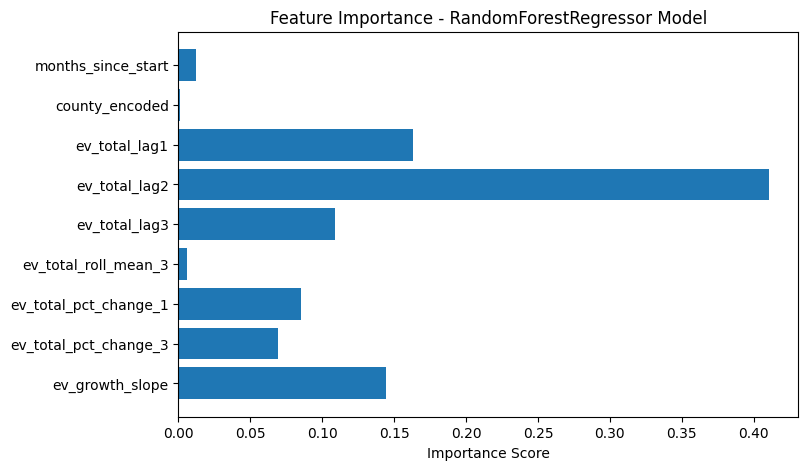

In [39]:
# Corrected the attribute name from get_feature_importance() to feature_importances_
importances = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.xlabel('Importance Score')
# Updated the title to reflect that the model is RandomForestRegressor
plt.title('Feature Importance - RandomForestRegressor Model')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


The bar chart visualizes the relative importance of various input features in predicting EV adoption using a Random Forest Regressor. Each bar represents the contribution of a specific feature to the model's predictive power. Key insights include:

Top Features:

ev_total_lag2 is the most influential feature, indicating that the EV count from two months prior is the strongest predictor of future EV adoption.

ev_total_lag1 and ev_growth_slope also have high importance, reflecting that recent trends and growth trajectories significantly affect predictions.

Moderately Important:

ev_total_pct_change_1 (recent percentage change) and ev_total_lag3 (three-month lag) play supporting roles in forecasting.

ev_total_pct_change_3 has a smaller, yet noticeable impact.

Least Important:
months_since_start, county_encoded, and ev_total_roll_mean_3 contribute very little to the model. This suggests that time index and county encoding have minimal standalone predictive value, and short rolling averages are less informative compared to lag features.
Overall, the chart highlights that lag-based features and recent growth patterns are the most effective predictors of EV adoption in this model setup.

A good growth rate, especially in technology, is subjective and depends on the specific context, but generally, anything above 10% per year is considered a strong growth rate. In the electric vehicle (EV) market, as per Fortune Business Insights suggests a 13.8% CAGR between 2024 and 2032.

Forecasting with Regression Model for Next 3 Years
Forecasting total eletric vehicles for a specific county (e.g., Clark)

In [40]:
# Define features and target
featuresX = ['County', 'county_encoded']

countyX = df[featuresX]


print("List of unique counties:")
print(df['County'].dropna().unique())

print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Atlantic' 'Autauga'
 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Berkshire'
 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard' 'Broward' 'Bryan' 'Bucks'
 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon' 'Carroll' 'Carson City'
 'Cascade' 'Champaign' 'Charles' 'Charleston' 'Charlottesville'
 'Chesapeake' 'Clackamas' 'Clark' 'Clay' 'Clinton' 'Cobb' 'Cochise'
 'Collier' 'Collin' 'Columbia' 'Contra Costa' 'Cook' 'Coryell'
 'Cumberland' 'Currituck' 'Dakota' 'Dale' 'Dallas' 'Dane' 'Danville'
 'DeKalb' 'Denton' 'Denver' 'Deschutes' 'District of Columbia'
 'Dorchester' 'Douglas' 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado'
 'El Paso' 'Escambia' 'Essex' 'Fairbanks North Star' 'Fairfax' 'Flathead'
 'Fort Bend' 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston'
 'Garfield' 'Geary' 'Goochland' 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton

County 'Kings' encoded as 130.


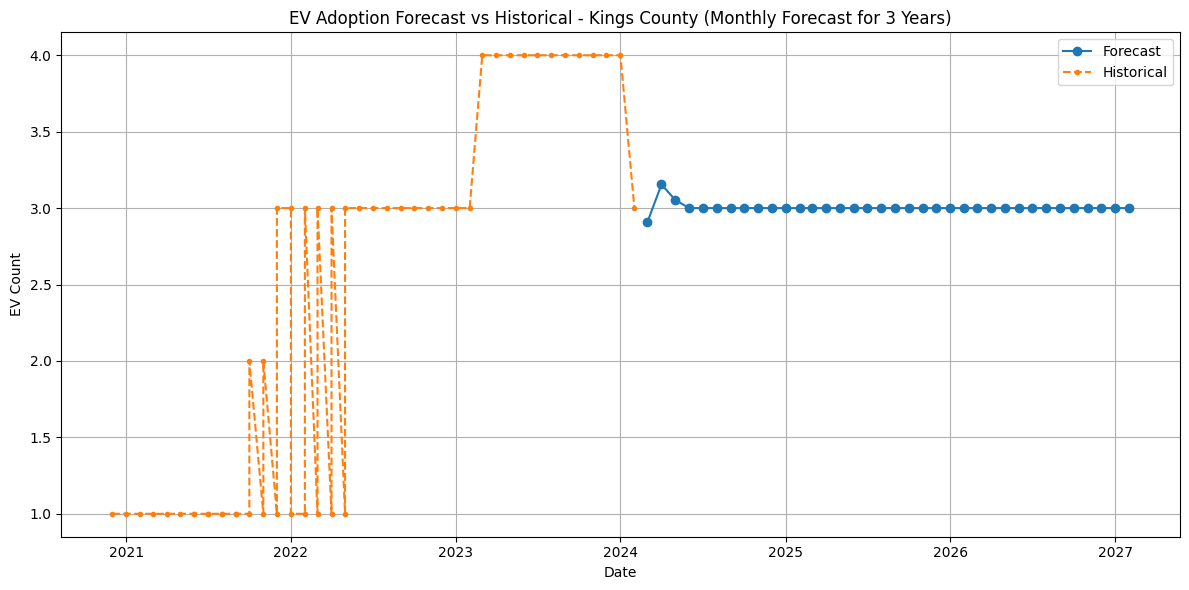

In [41]:
# Set your county name
county = "Kings"

# Encode county
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}.")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
    exit()

# Filter historical data
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
slope_history = []
months_since_start = county_df['months_since_start'].max()

historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

    # Compute slope
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    # Construct new row (removed year/month/numeric_date/acceleration)
    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    # Predict
    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    # Update rolling histories
    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['year'], latest_row['month'] = y, m

# Forecast DataFrame
forecast_df = pd.DataFrame(future_rows)

# Combine and plot
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'], label=source,
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"EV Adoption Forecast vs Historical - {county} County (Monthly Forecast for 3 Years)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

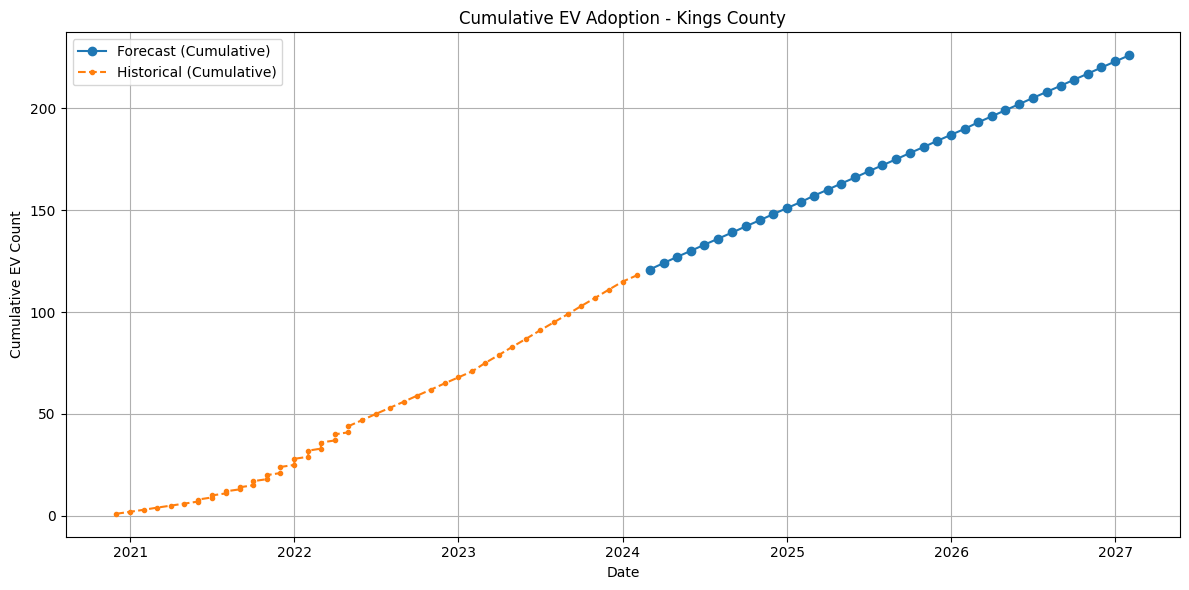

In [42]:
# --- Sort by date to ensure proper cumulative behavior ---
combined = combined.sort_values("Date")

# --- Calculate cumulative EV count ---
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# --- Plot cumulative EV adoption ---
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Forecasting for Top-5 Counties

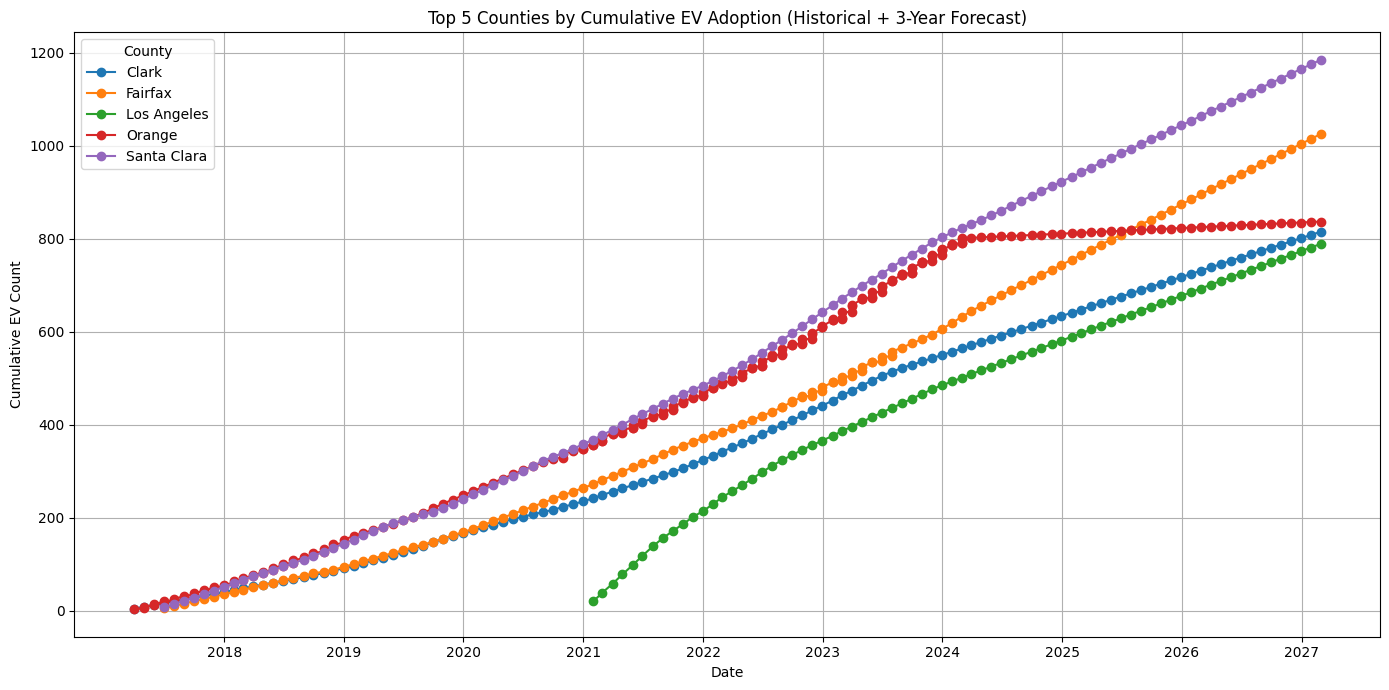

In [43]:
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

Final Model Testing

In [44]:
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [45]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [46]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.
